In [1]:

# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)


# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


import numpy as np
import matplotlib.pylab as plt
np.random.seed(10)

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

In [2]:
def ReadGalaxPy(path_program = '../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = True):    
    class Curated_sample():
        ''' Class to store the redshift and colors of observed galaxies,
            and the redshift, Mpeak, colors, and "weights" of simulated
            galaxies whose colors are compatible with those of observed
            galaxies.

            The observed sample include galaxies from SDSS
            (SDSS+BOSS+eBOSS), DEEP2, and VIPERS.

            The simulated sample was created by sampling the parameter of
            GALAXPY using a LH.

            The weights of simulated galaxies are related to the number
            density of observed galaxies in the same region of the color
            space.

            You only have to care about the method load_structure. '''

        def __init__(self):
            self.arr_c = []
            self.arr_z = []
            self.arr_m = []
            self.arr_w = []

        def append(self, c, z, m, w):
            self.arr_c.append(c)
            self.arr_z.append(z)
            self.arr_m.append(m)
            self.arr_w.append(w)

        def ndarray(self):
            self.arr_c = np.concatenate(self.arr_c)
            self.arr_z = np.concatenate(self.arr_z)
            self.arr_m = np.concatenate(self.arr_m)
            self.arr_w = np.concatenate(self.arr_w)

        def save_struct(self, name):
            np.save(name + 'c.npy', self.arr_c)
            np.save(name + 'z.npy', self.arr_z)
            np.save(name + 'm.npy', self.arr_m)
            np.save(name + 'w.npy', self.arr_w)

        def load_struct(self, name):
            self.arr_c = np.load(name + 'c.npy')
            self.arr_z = np.load(name + 'z.npy')
            self.arr_m = np.load(name + 'm.npy')
            self.arr_w = np.load(name + 'w.npy')

        def duplicate_data(self, zrange):
            aa = np.where((self.arr_w > 50)
                          & (self.arr_z >= zrange[0])
                          & (self.arr_z < zrange[1]))[0]
            print(aa.shape)
            cc = np.repeat(aa, self.arr_w[aa].astype(int))
            self.arr_cn = self.arr_c[cc, :]
            self.arr_zn = self.arr_z[cc]
            self.arr_mn = self.arr_m[cc]


    def read_curated_data():
        run_path = path_program + 'runs/run_z3/'

        sim_q = Curated_sample()  # simulated colors quenched galaxies
        sim_s = Curated_sample()  # simulated colors star-forming galaxies
        obs_q = Curated_sample()  # observed colors quenched galaxies
        obs_s = Curated_sample()  # observed colors star-forming galaxies

        obs_q.load_struct(run_path + 'str_obs_q')
        obs_s.load_struct(run_path + 'str_obs_s')
        sim_q.load_struct(run_path + 'str_sim_q')
        sim_s.load_struct(run_path + 'str_sim_s')

        print(sim_q.arr_c.shape)
        print(sim_s.arr_c.shape)
        print(obs_q.arr_c.shape)
        print(obs_s.arr_c.shape)

        return sim_q, sim_s, obs_q, obs_s


    sim_q, sim_s, obs_q, obs_s = read_curated_data()

    if sim_obs_combine:
        train_datafile = 'GalaxPy'

        # 2.0 ####### TRAIN USING SIMULATION, TEST OBSERVATION ####

        Trainfiles = np.append(sim_q.arr_c, sim_s.arr_c, axis=0)
        TrainZ = np.append(sim_q.arr_z, sim_s.arr_z, axis=0)

        Trainfiles = np.delete(Trainfiles, (4), axis=1)  ## deleting z-Y

        Testfiles = np.append(obs_q.arr_c, obs_s.arr_c, axis=0)
        TestZ = np.append(obs_q.arr_z, obs_s.arr_z, axis=0)

        TrainshuffleOrder = np.arange(Trainfiles.shape[0])
        np.random.shuffle(TrainshuffleOrder)

        Trainfiles = Trainfiles[TrainshuffleOrder]
        TrainZ = TrainZ[TrainshuffleOrder]

        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]
        TestZ = TestZ[TestshuffleOrder]

        # X_train = Trainfiles[:num_train]  # color mag
        # X_test = Trainfiles[:num_test]  # color mag

        # y_train = TrainZ[:num_train]  # spec z
        # y_test = TrainZ[:num_test]  # spec z

        #### THIS PART WAS WRONG above --- incorrect test and train -- BOTH WERE SAME ####

        X_train = Trainfiles[:num_train]  # color mag
        X_test = Testfiles[:num_test]  # color mag

        y_train = TrainZ[:num_train]  # spec z
        y_test = TestZ[:num_test]  # spec z

    else:
        train_datafile = 'SDSS'
        # 1.1 ####### SIMULATED: QUENCHED ONLY ############
        # Trainfiles = sim_q.arr_c
        # TrainZ = sim_q.arr_z

        # 1.2 ### SIMULATED: QUENCHED + STAR FORMATION ####

        # Trainfiles =np.append( sim_q.arr_c, sim_s.arr_c, axis = 0)
        # TrainZ = np.append( sim_q.arr_z, sim_s.arr_z, axis = 0)

        # 1.3 ####### OBSERVED: QUENCHED + STAR FORMATION ####

        Trainfiles = np.append(obs_q.arr_c, obs_s.arr_c, axis=0)
        TrainZ = np.append(obs_q.arr_z, obs_s.arr_z, axis=0)

        TrainshuffleOrder = np.arange(Trainfiles.shape[0])
        np.random.shuffle(TrainshuffleOrder)

        Trainfiles = Trainfiles[TrainshuffleOrder]
        TrainZ = TrainZ[TrainshuffleOrder]

        # 1 #################################

        X_train = Trainfiles[:num_train]  # color mag
        X_test = Trainfiles[num_train + 1: num_train + num_test]  # color mag

        X_train = Trainfiles[:num_train]  # color mag
        X_test = Trainfiles[num_train + 1: num_train + num_test]  # color mag

        y_train = TrainZ[:num_train]  # spec z
        y_test = TrainZ[num_train + 1: num_train + num_test]  # spec z

    ############## THINGS ARE SAME AFTER THIS ###########


    if logTrue:
        y_test = np.log10(y_test)
        y_train = np.log10(y_train)

    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)

    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin

In [3]:

def ReadCosmosDraw_UM(path_program = '../../Data/fromGalaxev/photozs/datasets/'):
    np.random.seed(12211)  
    fileIn = path_program + 'Training_data_UM_random/all_finite_col_mag_sdss.npy'
    #fileInColors = path_program + 'new_cosmos_sdss/all_col_sdss.npy'

    TrainfilesColors = np.load(fileIn)
    #TrainfilesMagI = np.load(fileInMagI)
    print('Train files shape', TrainfilesColors.shape)

    min_col = -5
    max_col = 5
    max_max = 25
    for ii in range(TrainfilesColors.shape[1]):
        aa = np.alltrue(np.isfinite(TrainfilesColors[:, ii, :]), axis=1)
        bb = (TrainfilesColors[:,ii,-1] < max_max) & (aa == True)
        cc = np.alltrue(TrainfilesColors[:, ii, :-1] < max_col, axis=1) & (bb == True)
        mask = np.alltrue(TrainfilesColors[:, ii, :-1] > min_col, axis=1)  & (cc == True)

    TrainfilesColors = TrainfilesColors[mask]
    print(TrainfilesColors.shape)


    #magI_low = 15
    #magI_high = 23

    fileInZ = path_program + 'Training_data_UM_random/redshifts.npy'
    TrainZ = np.load(fileInZ)



    Trainfiles = np.zeros(shape=(TrainfilesColors.shape[0]*TrainfilesColors.shape[1], TrainfilesColors.shape[2] + 1))

    for galID in range(TrainfilesColors.shape[0]):

            trainfiles100 = np.append(TrainfilesColors[galID, :, :] , TrainZ[:, None], axis=1)

            train_ind_start = galID*TrainfilesColors.shape[1]
            train_ind_end = galID*TrainfilesColors.shape[1] + TrainfilesColors.shape[1]

            Trainfiles[train_ind_start: train_ind_end] = trainfiles100

    print('Train files shape (with z)', Trainfiles.shape)


    TrainshuffleOrder = np.arange(Trainfiles.shape[0])
    np.random.shuffle(TrainshuffleOrder)
    Trainfiles = Trainfiles[TrainshuffleOrder]

    Test_VAL = False  ## -- doesn't work
    if Test_VAL: 

        fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        Testfiles = np.load(fileIn)
        print('Test files shape:', Testfiles.shape)


        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]
        X_train = Trainfiles[:num_train, :-1]  # color mag
        X_test = Testfiles[:num_test, 1:]  # color mag
        
        y_train = Trainfiles[:num_train, -1]  # spec z
        y_test = Testfiles[:num_test, 0] # spec z


    TestSynth = False

    if TestSynth:

        X_train = Trainfiles[:num_train, :-1]  # color mag
        X_test = Trainfiles[num_train + 1: num_train + num_test, :-1]  # color mag


        y_train = Trainfiles[:num_train, -1]   # spec z
        y_test = Trainfiles[num_train + 1: num_train + num_test, -1]  # spec z


    ##################################################
    ##################################################

    TestSDSS = False  ## Dont use this one -- it's not really SDSS
    if TestSDSS:

        #     fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        fileIn = path_program + 'Data_from_observations_new/SDSS_cols.npy'
        TestfilesColors = np.load(fileIn)
        fileIn = path_program + 'Data_from_observations_new/SDSS_iband.npy'
        TestfilesMag = np.load(fileIn)   
        
        Testfiles = np.append(TestfilesColors, TestfilesMag[:, None], axis=1)


        # TrainshuffleOrder = np.arange(Trainfiles.shape[0])
        # np.random.shuffle(TrainshuffleOrder)

        # Trainfiles = Trainfiles[TrainshuffleOrder]

        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]

        X_train = Trainfiles[:num_train, :-1]  # color mag
        X_test = Testfiles[:num_test, 1:]  # color mag
        y_train = Trainfiles[:num_train, -1]  # spec z
        y_test = Testfiles[:num_test, 0] # spec z

    TestSDSS_2 = True
    if TestSDSS_2:

        #     fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        fileIn_col = path_program + 'Training_data_UM_random/SDSS_col_val.npy'
        fileIn_z = path_program + 'Training_data_UM_random/SDSS_zz_val.npy'
        
        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)
  
        
        Testfiles = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]

        X_train = Trainfiles[:num_train, :-1]  # color mag
        X_test = Testfiles[:num_test, 1:]  # color mag
        y_train = Trainfiles[:num_train, -1]  # spec z
        y_test = Testfiles[:num_test, 0] # spec z
    ############################################################
    ############## THINGS ARE SAME AFTER THIS ###########

    if logTrue:
        y_test = np.log10(y_test)
        y_train = np.log10(y_train)


    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)

    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin

In [4]:

def ReadSDSS(path_program = '../../Data/fromGalaxev/photozs/datasets/'):
    np.random.seed(12211)  

    TestSDSS_2 = True
    if TestSDSS_2:

        #     fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        fileIn_col = path_program + 'Training_data_UM_random/SDSS_col_val.npy'
        fileIn_z = path_program + 'Training_data_UM_random/SDSS_zz_val.npy'
        
        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)

        print('number of SDSS datapoints', str(Testfiles_z.shape[0]))
  
        
        Testfiles = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

        TestshuffleOrder = np.arange(Testfiles.shape[0])
        np.random.shuffle(TestshuffleOrder)

        Testfiles = Testfiles[TestshuffleOrder]

        X_train = Testfiles[:num_train, 1:]  # color mag
        X_test = Testfiles[num_train + 1:num_train + num_test, 1:]  # color mag
        y_train = Testfiles[:num_train, 0]  # spec z
        y_test = Testfiles[num_train + 1:num_train + num_test, 0] # spec z
    ############################################################
    ############## THINGS ARE SAME AFTER THIS ###########

    if logTrue:
        y_test = np.log10(y_test)
        y_train = np.log10(y_train)


    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)

    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin

In [6]:

def ReadFSPS(path_program = '../../Data/fromGalaxev/photozs/datasets/'):
    np.random.seed(12211)  

    fsps_ip = np.load('../../Data/fromGalaxev/photozs/datasets/data_march_2020/fsps_sdss_join_col_mag.npy')
    # (ngal, nprop, nredshift, ncol)
    ngal, nprop, nz, ncol = fsps_ip.shape
    fsps_reshaped = fsps_ip.reshape(-1, nz, ncol)
    print(fsps_reshaped.shape)
    fsps_reshaped = fsps_reshaped.reshape(-1, ncol)
    print(fsps_reshaped.shape)

    fsps_ip_z= np.load('../../Data/fromGalaxev/photozs/datasets/data_march_2020/fsps_sdss_join_zz.npy')
    ngal, nprop, nz = fsps_ip_z.shape
    fsps_z_reshaped = fsps_ip_z.reshape(-1, nz)
    print(fsps_z_reshaped.shape)
    fsps_z_reshaped = fsps_z_reshaped.reshape(-1)
    print(fsps_z_reshaped.shape)

    fsps_ip_flag = np.load('../../Data/fromGalaxev/photozs/datasets/data_march_2020/fsps_sdss_join_flag_zz.npy')
    ngal, nprop, nz = fsps_ip_flag.shape
    fsps_flag_reshaped = fsps_ip_flag.reshape(-1, nz)
    print(fsps_flag_reshaped.shape)
    fsps_flag_reshaped = fsps_flag_reshaped.reshape(-1)
    print(fsps_flag_reshaped.shape)

    if linear_z:
        z_index = (fsps_flag_reshaped == 0)
    else:
        z_index = (fsps_flag_reshaped == 1)

    Trainfiles = np.append(fsps_z_reshaped[z_index][:, None], fsps_reshaped[z_index], axis=1) 


    min_max_cuts = False
    if min_max_cuts:
        min_col = -5
        max_col = 5
        max_max = 25
        TrainfilesColors = Trainfiles[1, :]
        for ii in range(TrainfilesColors.shape[1]):
            aa = np.alltrue(np.isfinite(TrainfilesColors[:, ii, :]), axis=1)
            bb = (TrainfilesColors[:,ii,-1] < max_max) & (aa == True)
            cc = np.alltrue(TrainfilesColors[:, ii, :-1] < max_col, axis=1) & (bb == True)
            mask = np.alltrue(TrainfilesColors[:, ii, :-1] > min_col, axis=1)  & (cc == True)

        TrainfilesColors = TrainfilesColors[mask]
        print(TrainfilesColors.shape)


    #magI_low = 15
    #magI_high = 23



    print('Train files shape (with z)', Trainfiles.shape)


    TrainshuffleOrder = np.arange(Trainfiles.shape[0])
    np.random.shuffle(TrainshuffleOrder)
    Trainfiles = Trainfiles[TrainshuffleOrder]

    ##################################################

    TestSDSS_2 = True
    if TestSDSS_2:

        #     fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        fileIn_col = path_program + 'Training_data_UM_random/SDSS_col_val.npy'
        fileIn_z = path_program + 'Training_data_UM_random/SDSS_zz_val.npy'
        
        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)

        print('number of SDSS datapoints', str(Testfiles_z.shape[0]))
  
        
        Testfiles1 = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)


    ############################################################
    ############## THINGS ARE SAME AFTER THIS ###########     

    TestDEEP2 = True
    if TestDEEP2:

        #     fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
        fileIn_col = path_program + 'data_march_2020/DEEP2_updated_colors.npy'
        fileIn_z = path_program + 'data_march_2020/DEEP2_updated_zz.npy'
        
        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)

        print('number of DEEP2 datapoints', str(Testfiles_z.shape[0]))
  
        
        Testfiles2 = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)


    ############################################################
    
    if CombineTrue:
        Testfiles = np.vstack((Testfiles1, Testfiles2))
    elif OnlySDSS:
        Testfiles = Testfiles1
    elif OnlyDEEP2:
        Testfiles = Testfiles2

    TestshuffleOrder = np.arange(Testfiles.shape[0])
    np.random.shuffle(TestshuffleOrder)

    Testfiles = Testfiles[TestshuffleOrder]

    X_train = Trainfiles[:num_train, 1:]  # color mag
    X_test = Testfiles[:num_test, 1:]  # color mag
    y_train = Trainfiles[:num_train, 0]  # spec z
    y_test = Testfiles[:num_test, 0] # spec z







    ##################################################

    # TestSDSS_2 = True
    # if TestSDSS_2:

    #     #     fileIn = path_program + 'new_cosmos_sdss/SDSS_val.npy'
    #     fileIn_col = path_program + 'Training_data_UM_random/SDSS_col_val.npy'
    #     fileIn_z = path_program + 'Training_data_UM_random/SDSS_zz_val.npy'
        
    #     TestfilesColors = np.load(fileIn_col)
    #     Testfiles_z = np.load(fileIn_z)
  
        
    #     Testfiles = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

    #     TestshuffleOrder = np.arange(Testfiles.shape[0])
    #     np.random.shuffle(TestshuffleOrder)

    #     Testfiles = Testfiles[TestshuffleOrder]

    #     X_train = Trainfiles[:num_train, :-1]  # color mag
    #     X_test = Testfiles[:num_test, 1:]  # color mag
    #     y_train = Trainfiles[:num_train, -1]  # spec z
    #     y_test = Testfiles[:num_test, 0] # spec z
    ############################################################
    ############## THINGS ARE SAME AFTER THIS ###########

    if logTrue:
        y_test = np.log10(y_test)
        y_train = np.log10(y_train)


    ## rescaling xmax/xmin
    xmax = np.max([np.max(X_train, axis=0), np.max(X_test, axis=0)], axis=0)
    xmin = np.min([np.min(X_train, axis=0), np.min(X_test, axis=0)], axis=0)

    X_train = (X_train - xmin) / (xmax - xmin)
    X_test = (X_test - xmin) / (xmax - xmin)

    #### RESCALING X_train, X_test NOT done yet -- (g-i), (r-i) ... and i mag -->> Color/Mag issue

    ymax = np.max([y_train.max(), y_test.max()])
    ymin = np.min([y_train.min(), y_test.min()])

    y_train = (y_train - ymin) / (ymax - ymin)
    y_test = (y_test - ymin) / (ymax - ymin)

    return X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin

In [27]:
#### FLAGS ####

train_mode = True
reSampleTest = True


logTrue = False

GalaxPyTrue = False

SDSSTrainTrue = False

UMTrue = False

FSPSTrue = True

if FSPSTrue:
    linear_z = True

    CombineTrue = False
    OnlySDSS = True
    OnlyDEEP2 = False

In [7]:
############training


if GalaxPyTrue: 

    Trainset = 'GalaxyPy'
    print(Trainset)

    num_train = 12000000 #800000
    num_test = 20000 #5000 #params.num_test # 32
    syntheticTrain = True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

    #### X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadGalaxPy(path_program = '../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = syntheticTrain)
    X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadGalaxPy(path_program = '../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = syntheticTrain)


if UMTrue:

    Trainset = 'UM'
    print(Trainset)


    num_train = 1000000 #2900000 #000#00 #800000 #12000000 #800000
    num_test = 20000 #5000 #params.num_test # 32
    syntheticTrain = True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

    X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadCosmosDraw_UM(path_program = '../../Data/fromGalaxev/photozs/datasets/')


if SDSSTrainTrue:

    Trainset = 'SDSS'
    print(Trainset)


    num_train = 800000 #2900000 #000#00 #800000 #12000000 #800000
    num_test = 20000 #5000 #params.num_test # 32
    syntheticTrain = True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

    X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadSDSS(path_program = '../../Data/fromGalaxev/photozs/datasets/')

if FSPSTrue:

    Trainset = 'FSPS'
    print(Trainset)


    num_train = 800000 #3000000# 800000 #17700000 #17709557 #2900000 #000#00 #800000 #12000000 #800000
    num_test = 20000 #5000 #params.num_test # 32
    syntheticTrain = True # (sim_obs_combine) True -- train using GalaxyPy, False -- train using

    X_train, y_train, X_test, y_test, ymax, ymin, xmax, xmin = ReadFSPS(path_program = '../../Data/fromGalaxev/photozs/datasets/')





FSPS
(178300, 200, 5)
(35660000, 5)
(178300, 200)
(35660000,)
(178300, 200)
(35660000,)
Train files shape (with z) (17709557, 6)
number of SDSS datapoints 839680
number of DEEP2 datapoints 13163


In [8]:

print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (800000, 5)
Size of output in training data: (800000,)
Size of features in test data: (20000, 5)
Size of output in test data: (20000,)


In [9]:
print(ymax, ymin)
print(xmin)
print(xmax)

1.2499946576176677 0.0015960353193804622
[-2.40347862 -2.51260948 -1.49261284 -1.82641602  5.75471672]
[  4.1243782    4.32191086   2.27371407   2.41539175 102.08090498]


In [10]:
# OnlySDSS
# 1.2499946576176677 0.0015960353193804622
# [-2.40347862 -2.51260948 -1.49261284 -1.82641602  5.75471672]
# [  4.1243782    4.32191086   2.27371407   2.41539175 102.08090498]

In [11]:
# 1.2499946576176677 0.002001323568020741
# [-0.16184216 -0.48782823 -1.00503029 -0.84960859  5.75471672]
# [ 37.72058638  39.87920271  29.47116997  23.20179149 102.08090498]

In [12]:
# ## BEST ONE SO FAR ###
# n_epochs = 32
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3  #16 # number of mixture components

# learning_rate = 1e-2
# decay_rate= 1e-2
# step=4 #100
# batch_size = 8192 # 1024 #8192

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [13]:
# ## BEST ONE SO FAR - fsps train sdss + deep2 test ###
# n_epochs = 16
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3  #16 # number of mixture components

# learning_rate = 1e-3
# decay_rate= 1e-2
# step=4#100
# batch_size = 8 #8192 # 1024 #8192

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [15]:
## BEST ONE SO FAR - fsps train sdss test ###
n_epochs = 12
D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
K = 3  #16 # number of mixture components

learning_rate = 1e-3
decay_rate= 1e-2
step=4#100
batch_size = 8 #8192 # 1024 #8192

save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [16]:
# ## BEST ONE SO FAR - UM ###
# n_epochs = 16
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3  #16 # number of mixture components

# learning_rate = 1e-3
# decay_rate= 1e-2
# step=4#100
# batch_size = 8 #8192 # 1024 #8192

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [17]:
# ## BEST ONE SO FAR - SDSS ###
# n_epochs = 64
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3  #16 # number of mixture components

# learning_rate = 1e-3
# decay_rate= 1e-3
# step=8#100
# batch_size = 512 #8192 # 1024 #8192

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [18]:
# ## BEST ONE SO FAR ###
# n_epochs = 32
# D = 5 #6  # number of features  (8 for DES, 6 for COSMOS)
# K = 3  #16 # number of mixture components

# learning_rate = 1e-3
# decay_rate= 1e-2
# step=4 #100
# batch_size = 32 #8192 # 1024 #8192

# save_mod = 'saved_hubs/new_tf2/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_step'+str(step)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

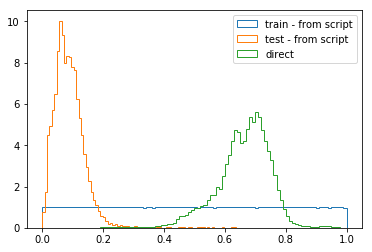

In [19]:
plt.figure(23)
# y_t = 10**(ymax - ymin)*(ymin + y_test)
y_t =  y_test
y_tr =  y_train

z_load = '../../Data/fromGalaxev/photozs/datasets/'+ 'Training_data_UM_random/SDSS_zz_val.npy'
y_f = np.load(z_load)
y_f = np.log10( y_f )
y_f = (y_f - y_f.min())/(y_f.max() - y_f.min())
# y_f = y_f
plt.hist(y_tr, normed=True, bins = 100, histtype='step', label='train - from script')
plt.hist(y_t, normed=True, bins = 100, histtype='step', label='test - from script')
plt.hist(y_f, normed=True, bins = 100, histtype='step', label='direct')
plt.legend()

In [20]:
# y_test.max()

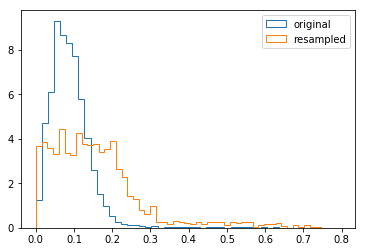

In [21]:
if reSampleTest :
    # test_argsort = np.argsort(y_test)
    # y_test = y_test[test_argsort]
    # X_test = X_test[test_argsort]

    num_y_test_select_per_bin = 100
    n_bins = 50
    np.random.seed(1)

    bins = np.linspace(y_test.min(), y_test.max(), n_bins)
    # bins = np.logspace(np.log10(y_test.min()+1e-2), np.log10(y_test.max()+1e-2), n_bins)
    inds = np.digitize(y_test, bins)

    # print(bins)
    # print(inds.shape, inds.max())
    # hist_y = np.histogram(y_test, bins = bins)
    # plt.plot(inds)
    # plt.plot(hist_y[0], '-.')
    # plt.yscale('log')

    resampled_ind = []

    for ind_i in range(n_bins):
        ind_bin = np.where(inds==ind_i)
        random_choices = np.min( [num_y_test_select_per_bin, np.size(ind_bin) ])
        index = np.random.choice(ind_bin[0], random_choices, replace=False)
        resampled_ind = np.append(resampled_ind, index)

    resampled_ind = resampled_ind.astype('int')


    plt.figure(23)
    plt.hist(y_test, normed=True, bins = 50, histtype='step', label='original')
    y_test1 = y_test[resampled_ind]
    X_test1 = X_test[resampled_ind]

    plt.hist(y_test1, normed=True, bins = 50, histtype='step', label='resampled')
    plt.legend()
    plt.show()

    # print(int_select)




In [22]:
if reSampleTest :
    y_test = y_test1
    X_test = X_test1

In [23]:
PairPlotTrue = True

if PairPlotTrue:
    import seaborn as sns
    import pandas as pd
    from IPython.display import Image

    ############ loading data ############
    # num_train = 800000

    # _, _, X_test, y_test, ymax, ymin, xmax, xmin = ReadGalaxPy(path_program = '../../../Data/fromGalaxev/photozs/datasets/', sim_obs_combine = False)

    # print("Size of features in training data: {}".format(X_train.shape))
    # print("Size of output in training data: {}".format(y_train.shape))
    # print("Size of features in test data: {}".format(X_test.shape))
    # print("Size of output in test data: {}".format(y_test.shape))

    num_data = 2000

    df_train = pd.DataFrame()

    # Add columns
    df_train['u-g'] = X_train[:num_data, 0]
    df_train['g-r'] = X_train[:num_data, 1]
    df_train['r-i'] = X_train[:num_data, 2]
    df_train['i-z'] = X_train[:num_data, 3]
    df_train['mag(i)'] = X_train[:num_data, 4]
    df_train['redshift'] = y_train[:num_data]


    df_test = pd.DataFrame()

    # Add columns
    df_test['u-g'] = X_test[:num_data, 0]
    df_test['g-r'] = X_test[:num_data, 1]
    df_test['r-i'] = X_test[:num_data, 2]
    df_test['i-z'] = X_test[:num_data, 3]
    df_test['mag(i)'] = X_test[:num_data, 4]
    df_test['redshift'] = y_test[:num_data]


    df_all = pd.concat([df_train.assign(dataset='train'), df_test.assign(dataset='test')])


    #### plotting ####
    g = sns.PairGrid(df_all, hue='dataset')
    g = g.map_upper(sns.scatterplot, alpha=0.8)
    g = g.map_lower(sns.kdeplot, n_levels=10, shade=True, shade_lowest=False, alpha=0.7)
    g = g.map_diag(sns.kdeplot, lw=2, shade=True)
    # g = g.map_diag(sns.distplot, hist=True, kde=False)
    g = g.add_legend()

    g.savefig("pairplot_best_fsps_both.png")

    plt.clf() # Clean parirplot figure from sns 
    Image(filename='pairplot_best_fsps_both.png') # Show pairplot as image

<Figure size 1139.38x1080 with 0 Axes>

In [28]:
output_shape = 1 

model_train = keras.Sequential([
    keras.layers.Dense(units=128, activation='relu', input_shape=(D,)),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K, output_shape)),
    tfp.layers.MixtureNormal(K, output_shape)])

# model_train = keras.Sequential([
#     keras.layers.Dense(units=32, activation='relu', input_shape=(D,)),
#     keras.layers.Dense(units=16, activation='relu'),
#     keras.layers.Dense(units=8, activation='relu'),
#     keras.layers.Dense(units=4, activation='relu'),
#     keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K, output_shape)),
#     tfp.layers.MixtureNormal(K, output_shape)])



# model = keras.Sequential([
#     keras.layers.Dense(units=32, activation='relu', input_shape=(D,)),
#     keras.layers.Dense(units=16, activation='tanh'),
#     keras.layers.Dense(units=8, activation='tanh'),
#     # keras.layers.Dense(tfp.layers.MixtureNormal.params_size(K, output_shape)),
#     # tfp.layers.MixtureNormal(K, output_shape)
#     keras.layers.Dense(units=K*3),
#     tfp.layers.DistributionLambda(lambda t: tfd.Independent(
#         tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(
#                 logits=tf.expand_dims(t[..., :K], -2)),
#                 components_distribution=tfd.Beta(1 + tf.nn.softplus(tf.expand_dims(t[..., K:2*K], -2)), 
#                 1 + tf.nn.softplus(tf.expand_dims(t[..., 2*K:],-2)))), 1))])


def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)


# callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)

# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1= decay_rate, amsgrad = True)
# model.compile(loss=negloglik, optimizer=opt, metrics=[])



callback = tf.keras.callbacks.LearningRateScheduler(lambda e: 0.001 if e < 5 else 0.0001)
checkpoint = ModelCheckpoint(save_mod + '.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint,callback,earlystopping]


opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1= decay_rate, amsgrad = True)
model_train.compile(loss=negloglik, optimizer=opt, metrics=[])
model_train.summary()

model = model_train

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 297       
_________________________________________________________________
mixture_normal_1 (MixtureNor ((None, 1), (None, 1))    0         
Total params: 15,561
Trainable params: 15,561
Non-trainable params: 0
__________________________________________________

In [25]:

if train_mode:
    # history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=4, callbacks=callbacks_list, verbose=1, validation_split=0.1)
    history = model_train.fit(X_train, y_train,  validation_data=(X_test, y_test), epochs=n_epochs, batch_size=batch_size, callbacks=[callback], verbose=2)

    model_train.save(save_mod + '.h5')
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs', fontsize = 28)
    plt.ylabel('Loss', fontsize = 28)

In [26]:
# model_train.save(save_mod + '.h5')
model.load_weights(save_mod + '.h5')

y_pred = model(X_test)
y_pred_mean = y_pred.components_distribution.mean() 
y_pred_std = y_pred.components_distribution.stddev()
y_pred_mode = y_pred.components_distribution.mode() 

OSError: Unable to open file (unable to open file: name = 'saved_hubs/new_tf2/Train_FSPS_lr_0.001_dr0.01_step4_ne12_k3_nt800000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
y_pred_mean[:, :, 0].shape

In [ ]:
y_pred_std[:, :, 0].shape

In [ ]:
# y_test[galID]

In [ ]:
y_arr = np.arange(0.01, 1, 0.01)
# print(y_arr)
log_p = []
for y_arr_val in y_arr:
    log_p.append(y_pred.log_prob(y_arr_val).numpy())


plt.figure(143, figsize=((10,8)))
for galID in range(1300, 1310):
    plt.plot(y_arr, np.exp(np.array(log_p).T[galID]), alpha = 0.7);
    plt.axvline(x=y_test[galID], color='black', alpha=0.5);
# plt.savefig('exp_log_p.png')
plt.show()


In [ ]:
y_pred.components_distribution.mode()

In [ ]:
y_pred.components_distribution.distribution.mean()

In [ ]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', color = '', comp=True):
  """Plots the mixture of Normal models to axis=ax comp=True plots all
  components of mixture model
  """

  x = np.linspace(-0.1, 1.1, 250)
  final = np.zeros_like(x)
  for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
    temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
    final = final + temp
    if comp:
#       ax.plot(x, temp, label='Normal ' + str(i), alpha =0.6)
      ax.plot(x, temp, 'k--', alpha =0.9)

#       ax.plot(x, temp/final.max(), alpha =0.5)

  ax.plot(x, final,label=label, color = color)
#   ax.plot(x, final/final.max(), label=label, color = color)

    
  ax.legend(fontsize=13)
  return final

def plot_pdfs(pred_means,pred_weights,pred_std, y,num=4, label = '', color = '', train=False, comp = False):
    np.random.seed(12)

    if train:
        obj = np.random.randint(0,num_train-1,num)
    else:
        obj = np.random.randint(0,num_test-1,num)
#     obj = [462, 667, 81]
    obj = [420, 102, 81]
    # obj = [4, 18, 81]
    
    print(obj)

    allfs = []
    for i in range(len(obj)):
        print(i)
        if (i==0):
            fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = label, color = color, comp=comp)
        else: fs = plot_normal_mix(pred_weights[obj][i], pred_means[obj][i], pred_std[obj][i], axes[i], label = '', color = color, comp=comp)

        axes[i].set_ylabel(r'${\rm PDF}$', fontsize = 22)
        allfs.append(fs)
        axes[i].axvline(x=y[obj][i], color='black', alpha=0.5)
        

    plt.xlabel('Photometric redshift', fontsize = 26)
    


In [ ]:
test_means = np.array(y_pred_mean[:, :, 0] )
test_std = np.array(y_pred_std[:, :, 0] )
test_weights = np.ones_like(test_means)

## plotting pdfs
from scipy import stats

nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(12, nrows*4), num='pdfs')
plot_pdfs(test_means,test_weights,test_std, y_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
# plot_pdfs(test_means_2,test_weights_2,test_std_2, y_test, num=nrows, label = 'Training with observational data', color = 'blue', train=False)

In [ ]:
test_means = np.array(y_pred_mean[:, :, 0] )
test_std = np.array(y_pred_std[:, :, 0] )
test_weights = np.ones_like(test_means)

## plotting pdfs




from scipy import stats

nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex = True, figsize=(12, nrows*4), num='pdfs')
plot_pdfs(test_means,test_weights,test_std, y_test, num=nrows, label = 'Training with synthetic data', color = 'red', train=False)
# plot_pdfs(test_means_2,test_weights_2,test_std_2, y_test, num=nrows, label = 'Training with observational data', color = 'blue', train=False)

In [ ]:
# fig = plt.figure(22)

ifPlotWeighted = True
# y_pred_mean_best = y_pred_mean[:, 0]
y_pred_mean_best = y_pred_mode[:, 0]
y_pred_std_best = y_pred_std[:, 0]


if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10,))
    # plt.scatter((ymax - ymin)*(ymin + y_test),(ymax - ymin)*(ymin + y_pred_mean_best), facecolors='r', s = 1)
    plt.scatter(y_test,y_pred_mean_best, facecolors='r', s = 1)


# plt.xlim(0.0, 1)
# plt.ylim(0.0, 1)
plotlims = [0, 1] #[ymin, ymax]
# plotlims = [ymin, ymax]
plt.plot(plotlims, plotlims, 'k')
plt.plot(plotlims, 0.85*np.array(plotlims), 'k-.')
plt.plot(plotlims, 1.15*np.array(plotlims), 'k-.')

# plt.ylabel(r'$z_{\rm phot}$', fontsize=30)
# plt.xlabel(r'$z_{\rm spec}$', fontsize=30)
plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)


# plt.legend(fontsize = 'large', markerscale=3., numpoints=3)
# plt.title('weight x mean')
plt.tight_layout()

plt.axes().set_aspect('equal')

# plt.xscale('log')
# plt.yscale('log')

leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()


In [ ]:
# fig = plt.figure(22)

ifPlotWeighted = True
# y_pred_mean_best = y_pred_mean[:, 0]
y_pred_mean_best = y_pred_mode[:, 0]
y_pred_std_best = y_pred_std[:, 0]

## Overall mean --- weight * mean
ifPlotWeighted = True

if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10))

#     y_pred = np.sum(pred_means_new*pred_weights_new, axis = 1)
#     y_pred_std_new = np.sum(pred_std_new*pred_weights_new, axis = 1)

    # # plt.scatter(y_test, y_pred, facecolors='k', s = 1)
#     plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
#       ymin + y_pred_std_new), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    
    plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred_mean_best), yerr= (ymax - ymin)*(
      ymin + y_pred_std_best ), fmt='ro', ecolor='k', ms = 5, alpha = 0.1, label = 'Training with synthetic data')

#     plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
#       ymin + y_pred_std), fmt='wo', ecolor='w', ms = 5, alpha = 0.8, label = 'Training with synthetic data')



    # plt.text(0.8, 2.0, datafile, horizontalalignment='center', verticalalignment='center')
    # plt.ylabel(r'$z_{pred}$', fontsize = 19)
    # plt.xlabel(r'$z_{true}$', fontsize = 19)

    # plt.title('weight x mean')
    # plt.tight_layout()
    # plt.show()



## Overall mean --- weight * mean
# ifPlotWeighted = True


# if ifPlotWeighted:

# #     y_pred_new2 = np.sum(pred_means_new2*pred_weights_new2, axis = 1)
# #     y_pred_std_new2 = np.sum(pred_std_new2*pred_weights_new2, axis = 1)

# #     plt.figure(22, figsize=(6,6))


#     # plt.scatter(y_test2, y_pred, facecolors='k', s = 1)
# #     plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred), yerr= (ymax2 - ymin2)*(
# #       ymin2 + y_pred_std_new2), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    
#     plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred_2), yerr= (ymax2 - ymin2)*(
#       ymin2 + y_pred_std_2), fmt='bo', ecolor='b', ms = 5, alpha = 0.3, label = 'Training with observational data')

# #     plt.errorbar((ymax2 - ymin2)*(ymin2 + y_test2), (ymax2 - ymin2)*(ymin2 + y_pred_2), yerr= (ymax2 - ymin2)*(
# #       ymin2 + y_pred_std_2), fmt='co', ecolor='c', ms = 5, alpha = 0.8, label = 'Training with observational data')



#     # plt.text(0.8, 2.0, datafile, horizontalalignment='center', verticalalignment='center')

# plt.xlim(0, 1)
# plt.ylim(0, 1)

# # plt.text(0.1, 0.9, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_obs_all, color = 'red' , size = 20)
# # plt.text(0.1, 0.85, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_combine_all, color = 'blue' , size = 20)
# plt.text(0.6, 0.2, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_obs_all, color = 'blue' , size = 20)
# plt.text(0.6, 0.1, r'$\sigma_{NMAD}$ = %.3f'%sigmaNMAD_combine_all, color = 'red' , size = 20)

# plt.text(0.1, 0.9, r'GalaxPy training', color = 'red' , size = 20)
# plt.text(0.1, 0.85, r'SDSS training', color = 'blue' , size = 20)

plt.plot([0, 1], [0, 1], 'k')
plt.plot([0, 1], 0.85*np.array([0, 1]), 'k-.')
plt.plot([0, 1], 1.15*np.array([0, 1]), 'k-.')

# plt.ylabel(r'$z_{\rm phot}$', fontsize=30)
# plt.xlabel(r'$z_{\rm spec}$', fontsize=30)


plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)

# plt.legend(fontsize = 'large', markerscale=3., numpoints=3)
# plt.title('weight x mean')
plt.tight_layout()

plt.axes().set_aspect('equal')

# plt.xscale('log')
# plt.yscale('log')

leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()


In [ ]:
# fig = plt.figure(22)

ifPlotWeighted = True
# y_pred_mean_best = y_pred_mean[:, 0]
y_pred_mean_best = y_pred_mode[:, 0]
y_pred_std_best = y_pred_std[:, 0]


if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10,))


    # # plt.scatter(y_test, y_pred, facecolors='k', s = 1)
#     plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
#       ymin + y_pred_std_new), fmt='bo', ecolor='r', ms = 2, alpha = 0.1)
    
    plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred_mean_best), yerr= (ymax - ymin)*(
      ymin + y_pred_std_best), fmt='ro', ecolor='k', ms = 5, alpha = 0.2, label = 'Training with synthetic data')

#     plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred), yerr= (ymax - ymin)*(
#       ymin + y_pred_std), fmt='wo', ecolor='w', ms = 5, alpha = 0.8, label = 'Training with synthetic data')





plt.xlim(0, 1)
plt.ylim(0, 1)



plt.plot([0, 1], [0, 1], 'k')
plt.plot([0, 1], 0.85*np.array([0, 1]), 'k-.')
plt.plot([0, 1], 1.15*np.array([0, 1]), 'k-.')




plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)


plt.tight_layout()

plt.axes().set_aspect('equal')


leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()


In [ ]:
import scipy.stats
# hist = np.histogram(scaler.inverse_transform(Y_train), 64)
nbins = 30

# y_train_log = np.log(y_train)
hist = np.histogram(y_train, nbins)
prior = scipy.stats.rv_histogram(hist)

import pandas as pd
from scipy import stats 
s = pd.Series(hist[0])
prior2 = stats.gaussian_kde(s)

In [ ]:
# plt.plot(prior2(x))

In [ ]:
# plt.hist(scaler.inverse_transform(Y_train), 100, normed=True);
plt.hist(y_train, nbins, normed=True)
x = np.linspace(y_test.min(), y_test.max(), nbins)
# x = np.linspace(0.05, 0.1, nbins)

# x = np.logspace(np.log10(y_test.min()), np.log10(y_test.max()), nbins)
plt.plot(x, prior.pdf(x))
plt.yscale('log')
plt.xlabel(r'$z$')
plt.show()

In [ ]:
# This returns the distribution q(M | x) for all clusters
outputs = model(X_test)
# outputs = model(X_train)
# xt = scaler.transform(x.reshape((-1,1)))
xt = x
logps = []

for i in range(len(x)):
      logps.append(outputs.log_prob(xt[i]).numpy())

logps = np.array(logps)

In [ ]:
logps.shape

In [ ]:
for i in np.arange(100,105):
  plt.figure()
  # plt.plot(x, np.exp(logps[:,-i]), label='posterior under training prior')
  plt.plot(x, np.exp(logps[:,-i])/prior.pdf(x), label='posterior under flat prior')
  plt.axvline(y_test[-i], color='k', linestyle = 'dashed', label='True value')
  # plt.axvline(y_train[-i], color='k', linestyle = 'dashed', label='True value')
  # plt.xscale('log')
  plt.xlabel(r'$z$')
  plt.legend()

In [ ]:
from scipy.integrate import simps
corrected_posterior = np.exp(logps)/(prior.pdf(x).reshape((-1,1)))

In [ ]:
y_pred_prior_mean = simps(x.reshape((-1,1))*corrected_posterior,x,axis=0)/simps(corrected_posterior,x,axis=0)

In [ ]:
y_pred_prior_mean.shape

In [ ]:
plt.figure(22, figsize=(10, 10,))


# plt.errorbar((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred_prior_mean), yerr= (ymax - ymin)*(ymin + y_pred_std_best), fmt='ro', ecolor='r', ms = 5, alpha = 0.3, label = 'Training with synthetic data')

plt.scatter((ymax - ymin)*(ymin + y_test), (ymax - ymin)*(ymin + y_pred_prior_mean), s = 10, alpha = 0.9, label = 'corrected posterior')


plt.xlim(0, 1)
plt.ylim(0, 1)

plt.plot([0, 1], [0, 1], 'k')
plt.plot([0, 1], 0.85*np.array([0, 1]), 'k-.')
plt.plot([0, 1], 1.15*np.array([0, 1]), 'k-.')

plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)

plt.tight_layout()

plt.axes().set_aspect('equal')


leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

# for artist, text in zip(leg.legendHandles, leg.get_texts()):
#     col = artist.get_color()
#     if isinstance(col, np.ndarray):
#         col = col[0]
#     text.set_color(col)
#     text.set_alpha(1.0)


plt.savefig('phoz_compare1.pdf', bbox_inches='tight')

plt.show()


In [ ]:
def binned_plot(X, Y, n=10, percentiles=[35, 50], ax=None, **kwargs):
    # Calculation
    calc_percent = []
    for p in percentiles:
        if p < 50:
            calc_percent.append(50-p)
            calc_percent.append(50+p)
        elif p == 50:
            calc_percent.append(50)
        else:
            raise Exception('Percentile > 50')

    bin_edges = np.linspace(X.min()*0.9999, X.max()*1.0001, n+1)

    dtype = [(str(i), 'f') for i in calc_percent]
    bin_data = np.zeros(shape=(n,), dtype=dtype)

    for i in range(n):
        y = Y[(X >= bin_edges[i]) & (X < bin_edges[i+1])]

        if len(y) == 0:
            continue

        y_p = np.percentile(y, calc_percent)

        bin_data[i] = tuple(y_p)

    # Plotting
    if ax is None:
        f, ax = plt.subplots()

    bin_centers = [np.mean(bin_edges[i:i+2]) for i in range(n)]
    for p in percentiles:
        if p == 50:
            ax.plot(bin_centers, bin_data[str(p)], **kwargs)
        else:
            ax.fill_between(bin_centers,
                            bin_data[str(50-p)],
                            bin_data[str(50+p)],
                            alpha=0.2,
                            **kwargs)

    return bin_data, bin_edges

In [ ]:
# replace y_true by y_test

import matplotlib as mpl
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

# ax1.plot(np.arange(13,16,0.1),np.arange(13,16,0.1),'k--')
_ = binned_plot(y_test, 
                y_pred_prior_mean, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax1)

# ax1.set_xlim(0, 1)
# ax1.set_ylim(0, 1)
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (M_\odot h^{-1})\right]$', fontsize=14)


ax2 = f.add_subplot(gs[1,0])

# ax2.plot(np.arange(13.,16,0.1),[0]*30,'k--')
_ = binned_plot(y_test, 
                y_pred_prior_mean - y_test, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax2)

# ax2.set_xlim(0, 1)
# ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (M_\odot h^{-1})\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14)

In [ ]:
m = y_test < ymin
plt.plot(x, corrected_posterior[:,m][:,0])
plt.axvline(y_test[m][0], ls='--', label='true value', color='m')
plt.axvline(y_pred_prior_mean[m][0], label='posterior mean', color='r')
plt.legend()

In [ ]:
y_pred_mode = x[np.exp(corrected_posterior).argmax(axis=0)]


In [ ]:
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

# ax1.plot(np.arange(13,16,0.1),np.arange(13,16,0.1),'k--')
_ = binned_plot(y_test, 
                y_pred_mode, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax1)

ax1.set_xlim(y_test.min(),y_test.max())
ax1.set_ylim(y_test.min(),y_test.max())
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (M_\odot h^{-1})\right]$', fontsize=14)

ax2 = f.add_subplot(gs[1,0])

# ax2.plot(np.arange(13,16,0.1),[0]*30,'k--')
_ = binned_plot(y_test, 
                y_pred_mode - y_test, 
                n=20, percentiles=[35,45,50], 
                color='b', ax=ax2)
# ax2.set_xlim(13.5,15.3)
# ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (M_\odot h^{-1})\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14)

In [ ]:
y_pred_mode.shape